In [29]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from slugify import slugify
import ast
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import booleanize
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats import hmean
from collections import defaultdict, Counter, OrderedDict
from copy import deepcopy

import math
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import operator
import functools

import csv
import random 
import reorder_list
from wordcloud import WordCloud

from inflection import singularize, pluralize
import copy
import string
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
s=set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /Users/dan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
artists = pd.read_pickle("H.pkl")
playlists = pd.DataFrame.transpose(pd.read_pickle("W.pkl"))

artists = pd.DataFrame.divide(artists,np.max(artists,axis=1),axis=0)
playlists = pd.DataFrame.divide(playlists,np.max(playlists,axis=1),axis=0)

artists = artists ** (3/4)
playlists = playlists ** (2/3)


In [31]:
artists_df = pd.read_pickle("artists_lookup.pkl")
playlists_df = pd.read_pickle("playlists_lookup.pkl")

artists_df = artists_df.reset_index().set_index('name').loc[artists.columns].reset_index().set_index('id')
playlists_df = playlists_df.loc[playlists.columns]


In [32]:
tracks_df = pd.read_pickle("unique_tracks.pkl")


In [33]:
component_names = artists.index.tolist()
assert component_names == playlists.index.tolist()

n_clusters = len(artists.index)
assert n_clusters == len(playlists.index)

n_artists = len(artists.columns)
n_playlists = len(playlists.columns)

print("clusters count:", n_clusters)
print("-------------------\n")

print("artists count:", n_artists)
print("playlists count:", n_playlists)


clusters count: 75
-------------------

artists count: 4803
playlists count: 8513


In [34]:
cur_map = {
    1: 74, 2: 60, 3: 59, 4: 46, 5: 72, 6: 75, 7: 36, 8: 67, 
    9: 48, 10: 73, 11: 65, 12: 11, 13: 57, 14: 43, 15: 52, 
    16: 34, 17: 17, 18: 69, 19: 30, 20: 71, 21: 54, 22: 68, 
    23: 70, 24: 23, 25: 47, 26: 64, 27: 58, 28: 66, 29: 32, 
    30: 22, 31: 44, 32: 7, 33: 61, 34: 33, 35: 38, 36: 50, 
    37: 51, 38: 45, 39: 14, 40: 6, 41: 35, 42: 8, 43: 3, 
    44: 26, 45: 5, 46: 62, 47: 13, 48: 41, 49: 18, 50: 53, 
    51: 28, 52: 27, 53: 37, 54: 63, 55: 39, 56: 9, 57: 4, 
    58: 24, 59: 25, 60: 31, 61: 21, 62: 42, 63: 55, 64: 15, 
    65: 49, 66: 56, 67: 40, 68: 1, 69: 29, 70: 2, 71: 20, 
    72: 10, 73: 12, 74: 16, 75: 19
}

label_dict = {
    1: "house (2605, daft punk)",
    2: "pop (1713, marshmello)",
    3: "soundtracks (1219, hans zimmer)",
    5: "downtempo (1160, air)",
    7: "electronic (1083, moby)",
    8: "cyberpunk (1051, perturbator)",
    12: "chill (931, tycho)",
    14: "abstract (887, chilly gonzales)",
    15: "geeky (858, rush)",
    16: "edm (844, tiesto)",
    17: "dance pop (841, beyonce)",
    18: "hard rock (837, metallica)",
    19: "indie (835, phoenix)",
    21: "hip hop (818, nas)",
    22: "chillhop (816, nujabes)",
    23: "metal (805, slipknot)",
    24: "modern rock (796, oasis)",
    30: "classic rock (709, beatles)",
    34: "90s rap (685, 2pac)",
    37: "ambient (611, album leaf)",
    39: "drum and bass (609, griz)",
    40: "pop punk (608, weezer)",
    42: "dubstep (567, skrillex)",
    47: "modern rap (538, drake)",
    51: "classical (491, mozart)",
    55: "chillwave (412, washed out)",
    61: "indietronica (358, the xx)",
    62: "nu jazz (345, zero 7)"
}

label_dict = dict( 
    (f"component_{cur_map[k]}", v) for (k, v) in label_dict.items() 
)


In [35]:
artists.rename(index=label_dict, inplace=True)
playlists.rename(index=label_dict, inplace=True)

drop_rows = [ component_name for component_name in component_names if component_name in artists.index ]

artists.drop(drop_rows, inplace=True)
playlists.drop(drop_rows, inplace=True)

assert artists.index.tolist() == playlists.index.tolist()


In [36]:
playlists

slug,7jvfS7fn7qx2HS3oMklAdw,4IgAuc1ur86KtYZAEnD6Q3,4LMlI2WnTGDqtKU8bTNGFS,4g4D9ayX9v2YWVx1ciKMFh,21iTXBzTLFliu8uQT6Espl,1flVHxeWkXnD7ms4ZaD2qP,4AeUPvi1HmPpuBx9jQ9zbF,4azy06YsbTmnNf6U25dFnN,305nOjGeunCGCmyfOn8ZLB,0IJpWHLc4SdiFsxm7Jfj7y,...,2Nn0NNoa41jomt7WA6w4kz,6P0Prt4auMrnp8E0hjpBBB,077VS7umBLBc10VgK6BXB1,2Fx3TuZ5O9w3IOYLqFbfQr,03Y3gDelBveftXRv6pZidT,5rLHlv0Avd3mgbNmMDOnXv,1p5ZeMzXpkEHYuM8zy2j3e,7DiLUwsIPRhAwEiVnCu7oU,1eUtArGA9QdSphQLArbvF6,2Ytz7ABT8ffnQHo5frgSpq
"pop punk (608, weezer)",0.000000,0.000000,0.000000,0.000000,0.000000,0.030960,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.055319,0.000000,0.000000,0.000000,0.000000,0.000000,0.040492,0.102523,0.000000
"dubstep (567, skrillex)",0.000000,0.000000,0.000000,0.000000,0.000000,0.006843,0.080432,0.028195,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026735,0.000000,0.000000,0.104767,0.000000
"chill (931, tycho)",0.000000,0.134138,0.000000,0.000000,0.000000,0.031066,0.123132,0.000000,0.000000,0.000000,...,0.012298,0.000000,0.000000,0.308817,0.000000,0.000000,0.000000,0.174835,0.011787,0.028649
"modern rap (538, drake)",0.000000,0.000000,0.000000,0.000000,0.000000,0.018131,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007312,0.000000,0.013358,0.000000,0.000000
"drum and bass (609, griz)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012332,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.035602,0.000000,0.000000,0.000000,0.003474
"dance pop (841, beyonce)",0.000000,0.000000,0.005079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021684,0.000000
"indietronica (358, the xx)",0.000000,0.000000,0.008011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.036016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"classic rock (709, beatles)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.035784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"modern rock (796, oasis)",0.000000,0.000000,0.000000,0.010097,0.000000,0.047538,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.012135,0.000000,0.000000,0.027793,0.000000,0.000000,0.099166,0.000000
"classical (491, mozart)",0.002406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002469,0.000000,0.000000,0.000000,0.000000,0.000000


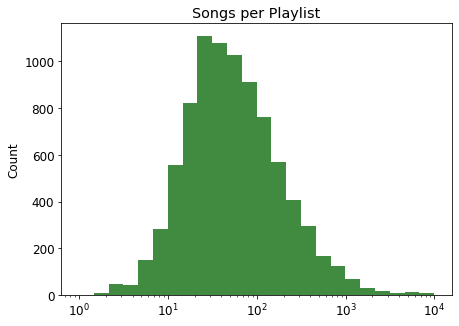

In [37]:
font = {
#     'family' : 'DejaVu Sans',
#         'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

track_counts = list(map(len,playlists_df.playlist_tracks))

plt.figure(figsize=(7,5))

pl = plt.hist(
    track_counts, 
    bins=np.logspace(np.log10(1),np.log10(np.max(track_counts)), 25),
    color="darkgreen", alpha=0.75
)

# pl.hist(data, bins=np.logspace(np.log10(0.1),np.log10(1.0), 50))
plt.gca().set_xscale("log")
plt.title("Songs per Playlist")
plt.ylabel("Count");

In [38]:
artists_df

,name
id,
16771,Billx
71843,Blausch
35337,Dr. Peacock
72928,Lefa
16222,Mandragora
...,...
18924,YUNGBLUD
15693,Manatee Commune
12135,Cigarettes After Sex


In [39]:
tracks_df

,name,album,duration_ms,year,track_artists,track_playlists
slug,,,,,,
2pnJ87yTVpkgtZh6Tq4vKh,Solar Sailer,TRON: Legacy,162075,2010,[1],"[65sliBWhuMUJTqWsKbm6rI, 6a18ZBZ297x009AnmSOh8..."
5lCJIgiqGmkc7uP6YJ0COc,Nightcall,Nightcall,259933,2010,[2],"[5M2lhmNrzpMXsUBQJFwJwF, 7nwhlivYaeYg35Qj818n4..."
6i8UuMvmxCqD0dh82Avk8t,End of Line,TRON Legacy: Reconfigured,318720,2011,"[3, 1]","[5M2lhmNrzpMXsUBQJFwJwF, 0jtjN8ahS5nrlK9ncZb0V..."
1ldYmnw4FViuG9jgiprY4C,AFG,8,565000,2014,[4],"[0jtjN8ahS5nrlK9ncZb0V0, 4UOZdB0cu7q8ESX3mUfWY..."
4zSbFrERDuBdZ1Bio9uee4,Looped,Kiasmos,360705,2014,[5],"[798NAA79qiRvYEjEZJHMZz, 7qlZ4HEK3EnGhqUI92CUs..."
...,...,...,...,...,...,...
1qpvZdfVgKqZC5SbnLdSMH,Crows On A Wire,The Last Hero,266988,2016,[13189],[3xkcfFadev2z4XLvdgjdLl]
0StjM2JrQoxppnqtkv3Jqk,Twilight,The Last Hero,254792,2016,[13189],[3xkcfFadev2z4XLvdgjdLl]
3PwKYa2i1d4rQ0eZUhKQzj,Island Of Fools,The Last Hero,300777,2016,[13189],[]


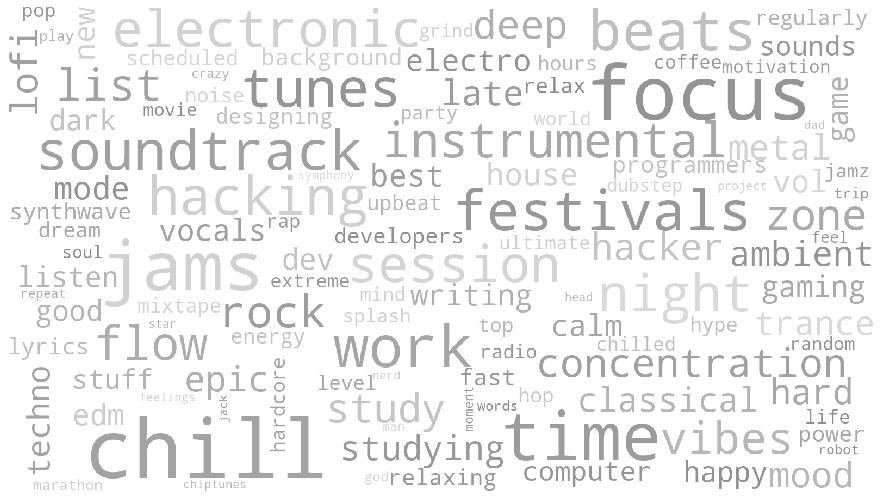

In [40]:
cur_str = " ".join(playlists_df.name).lower()
exclude = set(string.punctuation)
cur_str = ''.join(ch for ch in cur_str if ch not in exclude)

cur_str = list(filter(lambda w: not w in s and len(w) > 2,cur_str.split()))
cur_counter = Counter(cur_str)

for cur_key, cur_value in copy.deepcopy(cur_counter).items():
    try:
        int(cur_key)
        del cur_counter[cur_key]
        continue
    except:
        pass
        
    other_key = None
    
    if cur_key != singularize(cur_key) and singularize(cur_key) in cur_counter:
        other_key = singularize(cur_key)
    elif cur_key != pluralize(cur_key) and pluralize(cur_key) in cur_counter:
        other_key = pluralize(cur_key)
        
    if other_key:
        other_value = cur_counter[other_key]

        if cur_value > other_value:
            cur_counter[cur_key] += other_value
            del cur_counter[other_key]
            continue
        else:
            cur_counter[other_key] += cur_value
            del cur_counter[cur_key]
            continue
        
    if cur_value >= 10 : continue
    del cur_counter[cur_key]
    
del cur_counter['👨\u200d💻']
del cur_counter["festivalplaylistio"]
del cur_counter["coding"]
del cur_counter["programming"]

del cur_counter["fcknye"]
del cur_counter["code"]
del cur_counter["dour"]
del cur_counter["shit"]
del cur_counter["bruxelless"]
del cur_counter["music"]
del cur_counter["playlist"]
del cur_counter["mix"]
del cur_counter["weekly"]
del cur_counter["working"]
del cur_counter["songs"]
del cur_counter["song"]
del cur_counter["like"]
del cur_counter["track"]
del cur_counter["tracks"]
del cur_counter["bitch"]
del cur_counter["get"]
del cur_counter["high"]
del cur_counter["keep"]
del cur_counter["things"]

wordcloud = WordCloud(width = 1600, height = 900,
                      collocations=False,background_color='white',max_font_size = 150).generate_from_frequencies(cur_counter)

#change the value in return to set the single color need, in hsl format.
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(55, 85)

# #create the wordcloud object
# wordcloud = WordCloud(background_color='white',max_font_size = 50).generate(tmp)

#change the color setting
wordcloud.recolor(color_func = grey_color_func)

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()




In [233]:
is_coding_list = []
init_year_list_mean = []
init_year_list_std = []

for cur_genre in playlists.index:
    raw_genre_playlists = playlists.loc[cur_genre]
    raw_genre_playlists = raw_genre_playlists[raw_genre_playlists > 1e-8]
    
    genre_playlists = playlists_df.loc[raw_genre_playlists.index.tolist()]
    
    is_coding = genre_playlists.is_coding * raw_genre_playlists
    is_not_coding = genre_playlists.is_programming * raw_genre_playlists
    
    is_coding_list.append(
        np.sum(is_coding) / ( np.sum(is_coding) + np.sum(is_not_coding) )
    )
    
    cur_set = set(raw_genre_playlists.index.tolist())
    
    cur_tracks = tracks_df.loc[[ 
        track_index for (track_index, track_playlists) 
        in zip(tracks_df.index.tolist(), tracks_df.track_playlists.values.tolist()) 
        if set(track_playlists) & cur_set
    ]]
    
    print(cur_tracks.track_artists)
    
    print(cur_tracks.track_playlists)
    
    break
    
#     raw_tracks = [ cur_track for cur_tracks in genre_playlists.playlist_tracks for cur_track in cur_tracks ]
#     genre_tracks = tracks_df.loc[raw_tracks]

#     raw_artists = [ cur_artist for cur_artists in genre_tracks.track_artists for cur_artist in cur_artists ]
#     genre_artists = artists_df.loc[raw_artists]
    
#     print(len(genre_artists))
#     print(len(genre_artists.dropna()))
#     break
    
#     init_year_list_mean.append(genre_playlists.init_year.mean())
#     init_year_list_std.append(genre_playlists.init_year.std())

    
# x = np.array([1, 2, 3, 4, 5])
# y = np.power(x, 2) # Effectively y = x**2
# e = np.array([1.5, 2.6, 3.7, 4.6, 5.5])

# plt.errorbar(init_year_list_mean, is_coding_list, None, init_year_list_std, linestyle='None', marker='^')
# # plt.gca().invert_yaxis()
# # plt.show()

# plt.yscale("log")
#     print(  )
#     is_coding /= ( is_coding + is_not_coding )
#     print(genre_playlists.is_coding)
#     print(raw_genre_playlists)
#     print()
#     print([ cur_playlist for cur_playlist in playlists.loc[cur_genre] if cur_playlist > 1e-8 ])
#     genre_playlists = playlists_df.loc[
#         playlists.loc[cur_genre]
#     ]
    
#     print(is_coding)
#     break
#     print(cur_genre)
#     for (cur_col, cur_val) in zip(playlists.columns, ):
#         if cur_val < 1e-8 : continue
#         print(cur_col)
#         print(cur_val)
#         break
#     break
# plt.scatter(is_coding_list,is_coding_list )
# plt.xlim(0,1)

slug
2pnJ87yTVpkgtZh6Tq4vKh               [1]
5lCJIgiqGmkc7uP6YJ0COc               [2]
6i8UuMvmxCqD0dh82Avk8t            [3, 1]
1ldYmnw4FViuG9jgiprY4C               [4]
4zSbFrERDuBdZ1Bio9uee4               [5]
                               ...      
6m1SZUYKZlMAHgFUIdQCP4    [24802, 18789]
1scxrRW07AypiT3zfKKMyc           [13189]
7sK9Xxr63paUTglk8hbGVT           [13189]
5f2KE1PrTIhURCyR5cVTkf           [13189]
4Ty4UUcF8cTZqhLAFhB1TW           [13189]
Name: track_artists, Length: 133154, dtype: object
slug
2pnJ87yTVpkgtZh6Tq4vKh    [65sliBWhuMUJTqWsKbm6rI, 6a18ZBZ297x009AnmSOh8...
5lCJIgiqGmkc7uP6YJ0COc    [5M2lhmNrzpMXsUBQJFwJwF, 7nwhlivYaeYg35Qj818n4...
6i8UuMvmxCqD0dh82Avk8t    [5M2lhmNrzpMXsUBQJFwJwF, 0jtjN8ahS5nrlK9ncZb0V...
1ldYmnw4FViuG9jgiprY4C    [0jtjN8ahS5nrlK9ncZb0V0, 4UOZdB0cu7q8ESX3mUfWY...
4zSbFrERDuBdZ1Bio9uee4    [798NAA79qiRvYEjEZJHMZz, 7qlZ4HEK3EnGhqUI92CUs...
                                                ...                        
6m1SZUYKZlMAHgFUIdQCP4          

In [224]:
list(zip(tracks_df.index.tolist(), tracks_df.track_playlists.values.tolist()))[0]

('2pnJ87yTVpkgtZh6Tq4vKh',
 ['65sliBWhuMUJTqWsKbm6rI',
  '6a18ZBZ297x009AnmSOh8d',
  '43oGGtmzZN0zz6Ucaxr2qD',
  '5M2lhmNrzpMXsUBQJFwJwF',
  '5CKRJXP50bADbWoeWovFQR',
  '5gWid1tXiJeuGihJF0Zv8E',
  '4MMZ3eTJDBOjJwk9qTM1vs',
  '4aMpqFlRr6rRysohmdc7FH',
  '5R0J4gtqJtFlQXYVx8EZG2',
  '4W1XdbBNqVhXlMiRnipEh7',
  '2bafWTJSZMAvNTKDogTOwk',
  '147LC9xmoXFEnG5F3uu828',
  '2bSjivjQBeI286aTfESj7S',
  '6rqPceSBu4Fk8F25mXbugZ',
  '14oOHYnhRncbL4S0bwAGLb',
  '2jCtNN5GClRSwdLM8aivD0',
  '6Vm8ZcUDhlKVtodCDUH4mI',
  '3mFZhNiGpZRyrG266V7c0E',
  '3pwOGV5sjVPIxBNaxqtkni',
  '5LSMyX5mU60nf7M4bU1xta',
  '2HXoHcFfVb8nhzxfvGWqFB',
  '48SBsnAeqIoXXEcTFZ1yha',
  '3c3PawVNCHmnq5zKWLEVOs',
  '0INjQD5LOqnDEubiagHOXc',
  '3sZEozajPwhFyyLNScAqcl',
  '41obuDZtiyW5mJHclOuJg4',
  '2JNfcL7JQGnxqz0WhdyHmJ',
  '6TcdRPy4IkzfF1O9awrUic',
  '2qGlufsLzb94hg0Ncbe272',
  '0M99KMtAmTPBlVjL7534xn',
  '1O4QYVItK1aLOBaRKpQ6aG',
  '1r4TUY6NXk6WpRzvMv7IEQ',
  '1C9wtZwdz78XSP980lkVVM',
  '4wluh9DeuOwAZjhHCx7YT6',
  '603VcebXhr7YcaJXBt

In [190]:


artists_df.loc[genre_tracks.loc["4PbZ1dClx4HnT67mPcbyXz"].track_artists.iloc[0]]

,name
id,
4310,M|O|O|N


In [78]:
is_coding_dict = defaultdict(float)
is_programming_dict = defaultdict(float)

for cur_genre in playlists.index:
    for (cur_col, cur_val) in zip(playlists.columns, playlists.loc[cur_genre]):
        if cur_val < 1e-8 : continue
        cur_playlist = playlists_df.loc[cur_col]
        
        is_coding_dict[cur_genre] += cur_val * cur_playlist.is_coding
        is_programming_dict[cur_genre] += cur_val * cur_playlist.is_programming
        
ll = []
xx = []
yy = []

for cur_genre in playlists.index:
    ll.append(cur_genre)
    xxx = is_coding_dict[cur_genre]
    yyy = is_programming_dict[cur_genre]
    
    xxx, yyy = [xxx, yyy] / (xxx+yyy)
    xx.append(xxx)
    yy.append(yyy)
    

name                                                           Coding
init_year                                                        2018
last_year                                                        2019
followers                                                           0
is_coding                                                           1
is_programming                                                      0
playlist_tracks     [5ETM3aBrDf45TWg9AgnWQD, 6yZAdQyPJtXjATvAT8ERQ...
log_followers                                                       0
playlist_artists    [Camp Lo, Camp Lo, Sam Bush, Wu-Tang Clan, The...
artist_counters     {'Camp Lo': 3, 'Sam Bush': 1, 'Wu-Tang Clan': ...
norm_followers                                                      0
Name: 1flVHxeWkXnD7ms4ZaD2qP, dtype: object


NameError: name 'asdf' is not defined

,name
id,
16771,Billx
71843,Blausch
35337,Dr. Peacock
72928,Lefa
16222,Mandragora
...,...
18924,YUNGBLUD
15693,Manatee Commune
12135,Cigarettes After Sex


(0, 0.5)

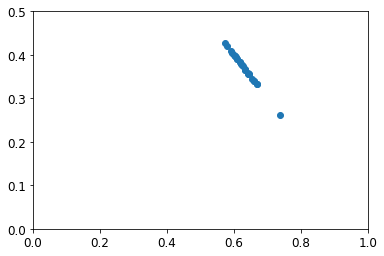

In [75]:
plt.scatter(xx,yy,label=ll)
plt.xlim(0,1)
plt.ylim(0,0.5)

In [76]:
playlists

slug,7jvfS7fn7qx2HS3oMklAdw,4IgAuc1ur86KtYZAEnD6Q3,4LMlI2WnTGDqtKU8bTNGFS,4g4D9ayX9v2YWVx1ciKMFh,21iTXBzTLFliu8uQT6Espl,1flVHxeWkXnD7ms4ZaD2qP,4AeUPvi1HmPpuBx9jQ9zbF,4azy06YsbTmnNf6U25dFnN,305nOjGeunCGCmyfOn8ZLB,0IJpWHLc4SdiFsxm7Jfj7y,...,2Nn0NNoa41jomt7WA6w4kz,6P0Prt4auMrnp8E0hjpBBB,077VS7umBLBc10VgK6BXB1,2Fx3TuZ5O9w3IOYLqFbfQr,03Y3gDelBveftXRv6pZidT,5rLHlv0Avd3mgbNmMDOnXv,1p5ZeMzXpkEHYuM8zy2j3e,7DiLUwsIPRhAwEiVnCu7oU,1eUtArGA9QdSphQLArbvF6,2Ytz7ABT8ffnQHo5frgSpq
"pop punk (608, weezer)",0.000000,0.000000,0.000000,0.000000,0.000000,0.030960,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.055319,0.000000,0.000000,0.000000,0.000000,0.000000,0.040492,0.102523,0.000000
"dubstep (567, skrillex)",0.000000,0.000000,0.000000,0.000000,0.000000,0.006843,0.080432,0.028195,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026735,0.000000,0.000000,0.104767,0.000000
"chill (931, tycho)",0.000000,0.134138,0.000000,0.000000,0.000000,0.031066,0.123132,0.000000,0.000000,0.000000,...,0.012298,0.000000,0.000000,0.308817,0.000000,0.000000,0.000000,0.174835,0.011787,0.028649
"modern rap (538, drake)",0.000000,0.000000,0.000000,0.000000,0.000000,0.018131,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007312,0.000000,0.013358,0.000000,0.000000
"drum and bass (609, griz)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012332,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.035602,0.000000,0.000000,0.000000,0.003474
"dance pop (841, beyonce)",0.000000,0.000000,0.005079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021684,0.000000
"indietronica (358, the xx)",0.000000,0.000000,0.008011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.036016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"classic rock (709, beatles)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.035784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"modern rock (796, oasis)",0.000000,0.000000,0.000000,0.010097,0.000000,0.047538,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.012135,0.000000,0.000000,0.027793,0.000000,0.000000,0.099166,0.000000
"classical (491, mozart)",0.002406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002469,0.000000,0.000000,0.000000,0.000000,0.000000


In [48]:
playlists

slug,7jvfS7fn7qx2HS3oMklAdw,4IgAuc1ur86KtYZAEnD6Q3,4LMlI2WnTGDqtKU8bTNGFS,4g4D9ayX9v2YWVx1ciKMFh,21iTXBzTLFliu8uQT6Espl,1flVHxeWkXnD7ms4ZaD2qP,4AeUPvi1HmPpuBx9jQ9zbF,4azy06YsbTmnNf6U25dFnN,305nOjGeunCGCmyfOn8ZLB,0IJpWHLc4SdiFsxm7Jfj7y,...,2Nn0NNoa41jomt7WA6w4kz,6P0Prt4auMrnp8E0hjpBBB,077VS7umBLBc10VgK6BXB1,2Fx3TuZ5O9w3IOYLqFbfQr,03Y3gDelBveftXRv6pZidT,5rLHlv0Avd3mgbNmMDOnXv,1p5ZeMzXpkEHYuM8zy2j3e,7DiLUwsIPRhAwEiVnCu7oU,1eUtArGA9QdSphQLArbvF6,2Ytz7ABT8ffnQHo5frgSpq
"pop punk (608, weezer)",0.000000,0.000000,0.000000,0.000000,0.000000,0.030960,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.055319,0.000000,0.000000,0.000000,0.000000,0.000000,0.040492,0.102523,0.000000
"dubstep (567, skrillex)",0.000000,0.000000,0.000000,0.000000,0.000000,0.006843,0.080432,0.028195,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026735,0.000000,0.000000,0.104767,0.000000
"chill (931, tycho)",0.000000,0.134138,0.000000,0.000000,0.000000,0.031066,0.123132,0.000000,0.000000,0.000000,...,0.012298,0.000000,0.000000,0.308817,0.000000,0.000000,0.000000,0.174835,0.011787,0.028649
"modern rap (538, drake)",0.000000,0.000000,0.000000,0.000000,0.000000,0.018131,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007312,0.000000,0.013358,0.000000,0.000000
"drum and bass (609, griz)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012332,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.035602,0.000000,0.000000,0.000000,0.003474
"dance pop (841, beyonce)",0.000000,0.000000,0.005079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021684,0.000000
"indietronica (358, the xx)",0.000000,0.000000,0.008011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.036016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"classic rock (709, beatles)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.035784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"modern rock (796, oasis)",0.000000,0.000000,0.000000,0.010097,0.000000,0.047538,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.012135,0.000000,0.000000,0.027793,0.000000,0.000000,0.099166,0.000000
"classical (491, mozart)",0.002406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002469,0.000000,0.000000,0.000000,0.000000,0.000000
